In [1]:
import os, math, sys
import pandas as pd
import pandapower as pp
import numpy as np

from pandapower.file_io import from_json, to_json

main_dir = os.path.abspath(os.path.join(os.path.abspath(""), ".."))
data_dir = '../Modified_116_LV_CSV'

if main_dir not in sys.path:
    sys.path.insert(0, main_dir)

from create_basic_network import debug_result, hc_violation

load c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\ortools\.libs\zlib1.dll...
load c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\ortools\.libs\abseil_dll.dll...
load c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\ortools\.libs\utf8_validity.dll...
load c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\ortools\.libs\re2.dll...
load c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\ortools\.libs\libprotobuf.dll...
load c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\ortools\.libs\highs.dll...
load c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\ortools\.libs\ortools.dll...

Created External Grid!


Created Transformer!


Created Shunt!


Created 117 Buses!


Created 115 Lines!


Debugging successful!
This pandapower network includes the following parameter tables:
   - bus (117 elements)
   - shunt (1 element)
   -

In [16]:
# Source data
source_df = pd.read_csv(os.path.join(data_dir,'Source.csv'), skiprows=1, sep='=')
source_dict = {i:float(row.iloc[0].split()[0]) for i, row in source_df.iterrows()}
print(source_dict)

source_dict['ISC1'] = source_dict['ISC1'] / 1000
source_dict['ISC3'] = source_dict['ISC3'] / 1000

# Transformer data
trafo_df = pd.read_csv(os.path.join(data_dir,'Transformer.csv'), skiprows=1, sep=';')
trafo_dict = trafo_df.iloc[0].to_dict()
print(trafo_dict)

{'Voltage': 11.0, 'pu': 1.05, 'ISC3': 3000.0, 'ISC1': 5.0}
{'Name': 'TR1', ' phases': 3, ' bus1': 'SourceBus', ' bus2': 1, ' kV_pri': 11, ' kV_sec': 0.416, ' MVA': 0.8, ' Conn_pri': ' Delta', ' Conn_sec': ' Wye', ' %XHL': 4, '% resistance': 0.4}


In [6]:
s_sc_mva = np.sqrt(3) * source_dict['Voltage'] * source_dict['ISC3'] #MVA

net = pp.create_empty_network()

bus_map = {}

hv_bus = pp.create_bus(net, name=trafo_dict[' bus1'], vn_kv=source_dict['Voltage'], type="b")
lv_bus = pp.create_bus(net, name=trafo_dict[' bus2'], vn_kv=trafo_dict[' kV_sec'], type="b")

bus_map[trafo_dict[' bus1']] = hv_bus
bus_map[trafo_dict[' bus2']] = lv_bus

pp.create_ext_grid(
    net, bus=hv_bus, vm_pu=source_dict['pu'],
    s_sc_max_mva=s_sc_mva,
    rx_max=0.1, rx_min=None,
    # max_p_mw=None, min_p_mw=None,
    # max_q_mvar=None, min_q_mvar=None, index=None,
    r0x0_max=0.1, x0x_max=1.0
)

pp.create_transformer_from_parameters(
    net=net, hv_bus=hv_bus, lv_bus=lv_bus,
    sn_mva=trafo_dict[' MVA'],
    vn_hv_kv=trafo_dict[' kV_pri'],
    vn_lv_kv=trafo_dict[' kV_sec'],
    vk_percent=trafo_dict[' %XHL'],
    vkr_percent=trafo_dict['% resistance'],
    pfe_kw=0.0, i0_percent=0.0, shift_degree=30, 
    name=trafo_dict['Name']
)

pp.create_shunt(
    net, bus=lv_bus,
    q_mvar=-0.01, p_mw=10e-3,
    vn_kv=trafo_dict[' kV_sec'],
    name="trafo_lv_shunt"
)

np.int64(0)

In [7]:
lines_df = pd.read_excel(os.path.join(data_dir, "Lines.xlsx"), skiprows=1)
lines_df['Length'] = lines_df['Length'] / 1000 # m to km
lines_df['Units'] = 'km'
lines_df.head()

lineCodes_df = pd.read_csv(os.path.join(data_dir, "LineCodes.csv"), skiprows=1, sep=';')

all_bus_ids = np.unique(lines_df[['Bus1', 'Bus2']].values.ravel('K'))
for id in all_bus_ids:
    id = math.floor(id)
    if id not in bus_map.keys():
        bus = pp.create_bus(net, name=id, vn_kv=trafo_dict[' kV_sec'], type="b")
        bus_map[id] = bus

In [8]:
lineCodes_df['max_i_ka'] = np.ones(len(lineCodes_df))

In [9]:
full_line_df = lines_df.merge(lineCodes_df, left_on="LineCode", right_on="Name", how="left")
# full_line_df.head(10)

net.line.drop(net.line.index, inplace=True)
for _, line in full_line_df.iterrows():
    # print(line)

    if (line['C0'] == 0): line['C0'] = 200 # nF/km
    if (line['C1'] == 0): line['C1'] = 200 # nF/km
    
    pp.create_line_from_parameters(
        net, from_bus = bus_map[math.floor(line['Bus1'])],
        to_bus = bus_map[math.floor(line['Bus2'])],
        length_km = line['Length'],
        r_ohm_per_km=line["R1"], r0_ohm_per_km=line["R1"] * 2,
        x_ohm_per_km=line["X1"], x0_ohm_per_km=line["X0"],
        c_nf_per_km=line["C1"], c0_nf_per_km=line["C0"],
        max_i_ka=line["max_i_ka"],
        name=line["Name_x"], type='cs',
    )

In [10]:
suspicious_lines = net.line[
    (np.isclose(net.line["length_km"], 0, rtol=1e-2)) |
    (np.isclose(net.line["r_ohm_per_km"], 0, rtol=1e-2)) |
    (np.isclose(net.line["x_ohm_per_km"], 0, rtol=1e-2))
]
suspicious_lines

,name,std_type,from_bus,to_bus,length_km,r_ohm_per_km,x_ohm_per_km,c_nf_per_km,g_us_per_km,max_i_ka,df,parallel,type,in_service,geo,r0_ohm_per_km,x0_ohm_per_km,c0_nf_per_km,g0_us_per_km


In [ ]:
net.trafo["vector_group"] = 'Dyn'
net.trafo["vk0_percent"] = net.trafo["vk_percent"]
net.trafo["vkr0_percent"] = net.trafo["vkr_percent"]
net.trafo["mag0_percent"] = 100
net.trafo["mag0_rx"] = 0
net.trafo["si0_hv_partial"] = 0.9
net.trafo["tap_phase_shifter"] = False

In [47]:
# to_json(net, os.path.join(data_dir, "no_load_network.json"))
net = from_json('../json_networks/no_load_network.json')
net

This pandapower network includes the following parameter tables:
   - bus (117 elements)
   - shunt (1 element)
   - ext_grid (1 element)
   - line (115 elements)
   - trafo (1 element)
 and the following results tables:
   - res_bus_3ph (117 elements)
   - res_line_3ph (115 elements)
   - res_trafo_3ph (1 element)
   - res_ext_grid_3ph (1 element)
   - res_shunt_3ph (1 element)

In [48]:
net.trafo['tap_po'] = 0
net.trafo['tap_neutral'] = 0
net.trafo['tap_min'] = -2
net.trafo['tap_max'] = 2
net.trafo['tap_step_percent'] = 2.5
net.trafo['tap_side'] = 'lv'

In [49]:
net.trafo

,name,std_type,hv_bus,lv_bus,sn_mva,vn_hv_kv,vn_lv_kv,vk_percent,vkr_percent,pfe_kw,...,in_service,vk0_percent,vkr0_percent,mag0_percent,mag0_rx,si0_hv_partial,vector_group,xn_ohm,k_st,tap_po
0,TR1,None,0,1,0.8,11.0,0.416,4.0,0.4,0.0,...,True,4.0,0.4,100.0,0.0,0.9,Dyn,0.0,1.0,0


In [50]:
from create_basic_network import trafo_dict
int(net.trafo.index[net.trafo.name==trafo_dict['Name']][0])

0

In [51]:
print(pp.create_transformer_from_parameters(
    net=net,
    hv_bus=int(net.bus.index[net.bus.name == 'SourceBus'][0]),
    lv_bus=int(net.bus.index[net.bus.name == 1][0]),
    sn_mva=0.8,
    vn_hv_kv=11,
    vn_lv_kv=0.416,
    vk_percent=4,
    vkr_percent=0.4,
    vk0_percent=4,
    vkr0_percent=0.4,
    mag0_percent=100,
    mag0_rx=0,
    si0_hv_partial=0.9,
    pfe_kw=0.0,
    i0_percent=0.0,
    shift_degree=30,
    tap_phase_shifter=False,
    vector_group="Dyn",
    name="TR2"
))

1


In [52]:
import pandapower.control as ppc

trafo_ctrl = ppc.DiscreteTapControl(
    net, element='trafo',
    element_index=int(net.trafo.index[net.trafo.name==trafo_dict['Name']][0]),
    vm_lower_pu=0.90, vm_upper_pu=1.10,
    vm_set_pu=1.0, side="lv",
    tol=0.01, in_service=True,
    trafotype="2W"
)

net

This pandapower network includes the following parameter tables:
   - bus (117 elements)
   - shunt (1 element)
   - ext_grid (1 element)
   - line (115 elements)
   - trafo (2 elements)
   - controller (1 element)
 and the following results tables:
   - res_bus_3ph (117 elements)
   - res_line_3ph (115 elements)
   - res_trafo_3ph (1 element)
   - res_ext_grid_3ph (1 element)
   - res_shunt_3ph (1 element)

In [53]:
net.controller

,object,in_service,order,level,initial_run,recycle
0,DiscreteTapControl of trafo 0,True,0.0,0,True,"{'trafo': True, 'gen': False, 'bus_pq': False}"


In [54]:
net.trafo.loc[:, ['tap_pos', 'tap_neutral', 'tap_min', 'tap_max', 'tap_step_percent', 'tap_side']]

,tap_pos,tap_neutral,tap_min,tap_max,tap_step_percent,tap_side
0,NaN,0.0,-2.0,2.0,2.5,lv
1,NaN,NaN,NaN,NaN,NaN,None


In [55]:
net.line.loc[:, ['length_km', 'r_ohm_per_km', 'r0_ohm_per_km']].describe()

,length_km,r_ohm_per_km,r0_ohm_per_km
count,115.000000,115.000000,115.000000
mean,0.010311,0.866948,1.173487
std,0.005717,0.402012,0.280478
min,0.002191,0.089000,0.319000
25%,0.006411,0.469000,1.200000
50%,0.009339,1.150000,1.200000
75%,0.013668,1.150000,1.200000
max,0.037663,1.257000,1.581000


In [56]:
import pandas as pd

def export_results(file_path, net, init='auto', max_iteration=100, tolerance_mva=1e-8):
    """
    Export all result DataFrames (attributes of net starting with 'res_') to an Excel file.
    
    Parameters:
    - file_path: str, path to the Excel file to save the results.
    - net: object containing result DataFrames as attributes starting with 'res_'.
    """

    try:
        pp.runpp_3ph(
            net, init=init,
            max_iteration=max_iteration,
            tolerance_mva=tolerance_mva,
            calc_voltage_angles=True,
            v_debug=True
        )
    except Exception as e:
        return e  # or raise e if you want the exception to propagate

    with pd.ExcelWriter(file_path) as writer:
        for attr in dir(net):
            if attr.startswith("res_"):
                df = getattr(net, attr)
                if isinstance(df, pd.DataFrame) and not df.empty:
                    sheet_name = attr[:31]  # Excel sheet names must be <= 31 characters
                    df.to_excel(writer, sheet_name=sheet_name)
    return True

def debug_result(net, init='auto', max_iteration=100, tolerance_mva=1e-8):
    try:
        pp.runpp_3ph(
            net, init=init,
            max_iteration=max_iteration,
            tolerance_mva=tolerance_mva,
            calc_voltage_angles=True,
            v_debug=True
        )
    except Exception as e:
        return False
    return True

In [57]:
pp.diagnostic(net)



_____________ PANDAPOWER DIAGNOSTIC TOOL _____________ 


 --------


 --------


 --------


 --------


 --------


 --------


 --------


 --------


 --------


 --------


 --------


 --------


 --------


 --------

_____________ END OF PANDAPOWER DIAGNOSTIC _____________ 


{'implausible_impedance_values': [{'line': [1,
    2,
    3,
    4,
    5,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    19,
    21,
    22,
    23,
    24,
    25,
    26,
    29,
    30,
    31,
    33,
    35,
    36,
    37,
    39,
    41,
    42,
    43,
    44,
    45,
    46,
    47,
    51,
    54,
    55,
    56,
    57,
    58,
    61,
    63,
    64,
    65,
    66,
    67,
    68,
    69,
    71,
    72,
    74,
    76,
    79,
    80,
    82,
    84,
    85,
    86,
    87,
    88,
    89,
    90,
    91,
    93,
    94,
    97,
    98,
    99,
    101,
    102,
    103,
    105,
    106,
    107,
    108,
    109,
    110,
    111,
    112,
    113,
    114]}]}

In [58]:
export_results("basic_network_results.xlsx", net)

True

In [62]:
bus_map = {
    name: bus_id for name, bus_id in zip(net.bus.name, net.bus.index)
}

In [59]:
# Create Loads
loads_df = pd.read_excel(os.path.join(data_dir, "Loads.xlsx"), skiprows=2)
# print(loads_df.head(10))
sample_loads = loads_df.sample(25)

net.asymmetric_load.drop(net.asymmetric_load.index, inplace=True)
load_map = {}
for _, row in sample_loads.iterrows():
    # print(_, '->', row)
    bus_id = math.floor(row['Bus'])
    pa = qa = pb = qb = pc = qc = 0
    if (bus_id in bus_map) & (row['phases'] in {'A', 'B', 'C'}):
        if row['phases']=='A':
            pa = row['kW']
            qa = row['kW'] * np.tan(np.arccos(row['PF']))
        elif row['phases']=='B':
            pb = row['kW']
            qb = row['kW'] * np.tan(np.arccos(row['PF']))
        else: # row['phases']=='C'
            pc = row['kW']
            qc = row['kW'] * np.tan(np.arccos(row['PF']))
        load = pp.create_asymmetric_load(
            net, bus=net.bus.index[net.bus.name==bus_id][0],
            p_a_mw=pa / 1000, q_a_mvar=qa / 1000,
            p_b_mw=pb / 1000, q_b_mvar=qb / 1000,
            p_c_mw=pc / 1000, q_c_mvar=qc / 1000,
            name=row['Name']
        )
        load_map[load] = row['Yearly']

# print(net.asymmetric_load)
export_results("batch_network_results.xlsx", net)

NameError: name 'bus_map' is not defined

In [ ]:
N = 1
batch = list(range(5, len(loads_df)+1, 5))
for b in batch:
    success = 0
    for i in range(N):
        sample_loads = loads_df.sample(b)

        net.asymmetric_load.drop(net.asymmetric_load.index, inplace=True)
        load_map = {}
        for _, row in sample_loads.iterrows():
            # print(_, '->', row)
            bus_id = math.floor(row['Bus'])
            pa = qa = pb = qb = pc = qc = 0
            if (bus_id in bus_map) & (row['phases'] in {'A', 'B', 'C'}):
                if row['phases']=='A':
                    pa = row['kW']
                    qa = row['kW'] * np.tan(np.arccos(row['PF']))
                elif row['phases']=='B':
                    pb = row['kW']
                    qb = row['kW'] * np.tan(np.arccos(row['PF']))
                else: # row['phases']=='C'
                    pc = row['kW']
                    qc = row['kW'] * np.tan(np.arccos(row['PF']))
                load = pp.create_asymmetric_load(
                    net, bus=net.bus.index[net.bus.name==bus_id][0],
                    p_a_mw=pa, q_a_mvar=qa,
                    p_b_mw=pb, q_b_mvar=qb,
                    p_c_mw=pc, q_c_mvar=qc,
                    name=row['Name']
                )
                load_map[load] = row['Yearly']

        if debug_result(net, init='flat'): success += 1
    print(f"[{b}]\tConvergence rate = {100 * success / N} %")

c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandapower\pf\create_jacobian.py:27: RuntimeWarning: invalid value encountered in divide
  dVm_x, dVa_x = dSbus_dV_numba_sparse(Ybus.data, Ybus.indptr, Ybus.indices, V, V / abs(V), Ibus)
c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandapower\pypower\newtonpf.py:441: MatrixRankWarning: Matrix is exactly singular
  dx = -1 * spsolve(J, F, permc_spec=permc_spec, use_umfpack=use_umfpack)
c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandapower\pf\runpp_3ph.py:468: RuntimeWarning: invalid value encountered in divide
  i_abc_it_wye = (np.divide(s_abc_pu, v_abc_it)).conjugate()
c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandapower\pf\runpp_3ph.py:469: RuntimeWarning: invalid value encountered in divide
  i_abc_it_delta = np.matmul(i_del_xfmn, (np.divide(s_abc_delta_pu, np.matmul
c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib

[5]	Convergence rate = 100.0 %


c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandapower\pypower\newtonpf.py:441: MatrixRankWarning: Matrix is exactly singular
  dx = -1 * spsolve(J, F, permc_spec=permc_spec, use_umfpack=use_umfpack)
c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandapower\pf\create_jacobian.py:27: RuntimeWarning: invalid value encountered in divide
  dVm_x, dVa_x = dSbus_dV_numba_sparse(Ybus.data, Ybus.indptr, Ybus.indices, V, V / abs(V), Ibus)
c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandapower\pf\runpp_3ph.py:468: RuntimeWarning: invalid value encountered in divide
  i_abc_it_wye = (np.divide(s_abc_pu, v_abc_it)).conjugate()
c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandapower\pf\runpp_3ph.py:469: RuntimeWarning: invalid value encountered in divide
  i_abc_it_delta = np.matmul(i_del_xfmn, (np.divide(s_abc_delta_pu, np.matmul
c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib

[10]	Convergence rate = 100.0 %


c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandapower\pf\create_jacobian.py:27: RuntimeWarning: invalid value encountered in divide
  dVm_x, dVa_x = dSbus_dV_numba_sparse(Ybus.data, Ybus.indptr, Ybus.indices, V, V / abs(V), Ibus)
c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandapower\pypower\newtonpf.py:441: MatrixRankWarning: Matrix is exactly singular
  dx = -1 * spsolve(J, F, permc_spec=permc_spec, use_umfpack=use_umfpack)
c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandapower\pf\runpp_3ph.py:468: RuntimeWarning: invalid value encountered in divide
  i_abc_it_wye = (np.divide(s_abc_pu, v_abc_it)).conjugate()
c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandapower\pf\runpp_3ph.py:469: RuntimeWarning: invalid value encountered in divide
  i_abc_it_delta = np.matmul(i_del_xfmn, (np.divide(s_abc_delta_pu, np.matmul
c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib

[15]	Convergence rate = 100.0 %


c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandapower\pf\create_jacobian.py:27: RuntimeWarning: invalid value encountered in divide
  dVm_x, dVa_x = dSbus_dV_numba_sparse(Ybus.data, Ybus.indptr, Ybus.indices, V, V / abs(V), Ibus)
c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandapower\pypower\newtonpf.py:441: MatrixRankWarning: Matrix is exactly singular
  dx = -1 * spsolve(J, F, permc_spec=permc_spec, use_umfpack=use_umfpack)


KeyboardInterrupt: 

In [ ]:
# Load by load:
load_problem = []

for _, row in loads_df.iterrows():
    net.asymmetric_load.drop(net.asymmetric_load.index, inplace=True)
    
    # print(_, '->', row)
    bus_id = math.floor(row['Bus'])
    pa = qa = pb = qb = pc = qc = 0
    if (bus_id in bus_map) & (row['phases'] in {'A', 'B', 'C'}):
        if row['phases']=='A':
            pa = row['kW']
            qa = row['kW'] * np.tan(np.arccos(row['PF']))
        elif row['phases']=='B':
            pb = row['kW']
            qb = row['kW'] * np.tan(np.arccos(row['PF']))
        else: # row['phases']=='C'
            pc = row['kW']
            qc = row['kW'] * np.tan(np.arccos(row['PF']))
        load = pp.create_asymmetric_load(
            net, bus=net.bus.index[net.bus.name==bus_id][0],
            p_a_mw=pa / 1000, q_a_mvar=qa / 1000,
            p_b_mw=pb / 1000, q_b_mvar=qb / 1000,
            p_c_mw=pc / 1000, q_c_mvar=qc / 1000,
            name=row['Name'] 
        )
    if not debug_result(net, init='flat'): load_problem.append(row['Name'])

load_problem

[]

In [63]:
# Create Loads
loads_df = pd.read_excel(os.path.join(data_dir, "Loads.xlsx"), skiprows=2)
# print(loads_df.head(10))

net.asymmetric_load.drop(net.asymmetric_load.index, inplace=True)
load_map = {}
for _, row in loads_df.iterrows():
    # print(_, '->', row)
    bus_id = math.floor(row['Bus'])
    pa = qa = pb = qb = pc = qc = 0
    if (bus_id in bus_map) & (row['phases'] in {'A', 'B', 'C'}):
        if row['phases']=='A':
            pa = row['kW']
            qa = row['kW'] * np.tan(np.arccos(row['PF']))
        elif row['phases']=='B':
            pb = row['kW']
            qb = row['kW'] * np.tan(np.arccos(row['PF']))
        else: # row['phases']=='C'
            pc = row['kW']
            qc = row['kW'] * np.tan(np.arccos(row['PF']))
        load = pp.create_asymmetric_load(
            net, bus=net.bus.index[net.bus.name==bus_id][0],
            p_a_mw=pa / 1000, q_a_mvar=qa / 1000,
            p_b_mw=pb / 1000, q_b_mvar=qb / 1000,
            p_c_mw=pc / 1000, q_c_mvar=qc / 1000,
            name=row['Name']
        )
        load_map[load] = row['Yearly']

# export_results("full_network_results.xlsx", net, init='flat', max_iteration=1000, tolerance_mva=1e-6)

In [64]:
net

This pandapower network includes the following parameter tables:
   - bus (117 elements)
   - asymmetric_load (55 elements)
   - shunt (1 element)
   - ext_grid (1 element)
   - line (115 elements)
   - trafo (2 elements)
   - controller (1 element)
 and the following results tables:
   - res_bus (117 elements)
   - res_line (115 elements)
   - res_trafo (2 elements)
   - res_ext_grid (1 element)
   - res_shunt (1 element)
   - res_bus_3ph (117 elements)
   - res_line_3ph (115 elements)
   - res_trafo_3ph (2 elements)
   - res_ext_grid_3ph (1 element)
   - res_shunt_3ph (1 element)

In [66]:
pp.runpp_3ph(net, max_iteration=1000)

LoadflowNotConverged: Power Flow nr did not converge after 1000 iterations!

Get maximum number of loads that converges

In [ ]:
N = 1000
batch = range(45, len(loads_df)+1)

# batch_loads = {}
# batch_bus = {}
max_batch = 0
for b in batch:
    for i in range(N):
        sample_loads = loads_df.sample(b)

        net.asymmetric_load.drop(net.asymmetric_load.index, inplace=True)
        for _, row in sample_loads.iterrows():
            # print(_, '->', row)
            bus_id = math.floor(row['Bus'])
            pa = qa = pb = qb = pc = qc = 0
            if (bus_id in bus_map) & (row['phases'] in {'A', 'B', 'C'}):
                if row['phases']=='A':
                    pa = row['kW']
                    qa = row['kW'] * np.tan(np.arccos(row['PF']))
                elif row['phases']=='B':
                    pb = row['kW']
                    qb = row['kW'] * np.tan(np.arccos(row['PF']))
                else: # row['phases']=='C'
                    pc = row['kW']
                    qc = row['kW'] * np.tan(np.arccos(row['PF']))
                load = pp.create_asymmetric_load(
                    net, bus=bus_map[bus_id],
                    p_a_mw=pa, q_a_mvar=qa,
                    p_b_mw=pb, q_b_mvar=qb,
                    p_c_mw=pc, q_c_mvar=qc,
                    name=row['Name']
                )

        if debug_result(net, init='flat'):
            # batch_loads[b] = list(net.asymmetric_load['name'])
            # batch_bus[b] = list(net.asymmetric_load['bus'])
            max_batch = b
            break

from pandapower.file_io import to_json

# to_json(net, os.path.join(data_dir, "{max_batch}_loads_network.json"))

C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pypower\newtonpf.py:337: MatrixRankWarning: Matrix is exactly singular
  dx = -1 * spsolve(J, F, permc_spec=permc_spec, use_umfpack=use_umfpack)
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pf\create_jacobian.py:28: RuntimeWarning: invalid value encountered in divide
  dVm_x, dVa_x = dSbus_dV_numba_sparse(Ybus.data, Ybus.indptr, Ybus.indices, V, V / abs(V), Ibus)
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandapower\pf\runpp_3ph.py:478: RuntimeWarning: invalid value encountered in divide
  i_abc_it_wye = (np.divide(s_abc_pu, v_abc_it)).conjugate()
C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalC

KeyboardInterrupt: 

In [ ]:
import pandapower.networks as pn
import pandapower as pp
offpeak_net = pn.ieee_european_lv_asymmetric('on_peak_566')

pp.runpp_3ph(
    offpeak_net, init='auto',
    max_iteration=100,
    tolerance_mva=1e-8,
    calc_voltage_angles=True,
    v_debug=True
)

In [ ]:
hc_violation(offpeak_net, mod='sto')

False

In [ ]:
farthest_load_net = from_json(os.path.join(data_dir, "farthest_load_network.json"))
print(farthest_load_net.asymmetric_load.p_a_mw)

inc = 5e-5
success = True
vm_pu = pd.DataFrame(columns=['p_a_mw', 'vm_a_pu', 'vm_b_pu', 'vm_c_pu'])
while success:
    # print(farthest_load_net.asymmetric_load.p_a_mw)
    if debug_result(farthest_load_net, init='flat'):
        new_row = pd.concat([
            farthest_load_net.asymmetric_load.p_a_mw,
            farthest_load_net.res_bus_3ph.loc[farthest_load_net.asymmetric_load.bus, ['vm_a_pu', 'vm_b_pu', 'vm_c_pu']].reset_index(drop=True)
        ], axis=1)
        vm_pu = pd.concat([vm_pu, new_row], ignore_index=True)

        farthest_load_net.asymmetric_load.p_a_mw += inc
    else:
        success = False

0    0.001
Name: p_a_mw, dtype: float64


C:\Users\vitor\AppData\Local\Temp\ipykernel_17036\202462447.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  vm_pu = pd.concat([vm_pu, new_row], ignore_index=True)


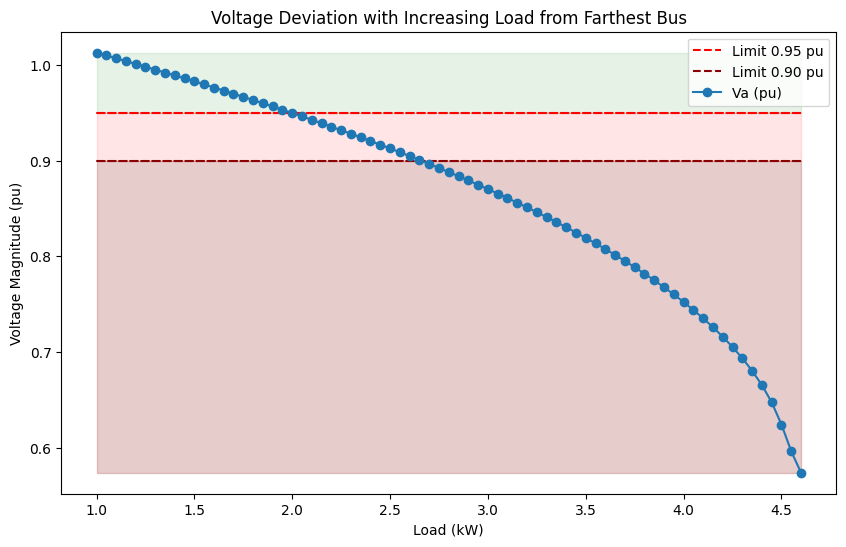

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

plt.fill_between(vm_pu['p_a_mw']*1000,
                 y1=vm_pu['vm_a_pu'].max(), y2=0.95,
                #  where=vm_pu['vm_a_pu'] < 0.95, 
                 interpolate=True, color='green', alpha=0.1)
plt.fill_between(vm_pu['p_a_mw']*1000,
                 y1=0.95, y2=0.9,
                #  where=vm_pu['vm_a_pu'] < 0.95, 
                 interpolate=True, color='red', alpha=0.1)
plt.fill_between(vm_pu['p_a_mw']*1000,
                 y1=0.9, y2=vm_pu['vm_a_pu'].min(),
                #  where=vm_pu['vm_a_pu'] < 0.95, 
                 interpolate=True, color='darkred', alpha=0.2)
plt.hlines(y=0.95, xmin=vm_pu['p_a_mw'].min()*1000,
           xmax=vm_pu['p_a_mw'].max()*1000, color='red', linestyle='--', label='Limit 0.95 pu')
plt.hlines(y=0.9, xmin=vm_pu['p_a_mw'].min()*1000,
           xmax=vm_pu['p_a_mw'].max()*1000, color='darkred', linestyle='--', label='Limit 0.90 pu')

plt.plot(vm_pu['p_a_mw']*1000, vm_pu['vm_a_pu'], label='Va (pu)', marker='o')
plt.title('Voltage Deviation with Increasing Load from Farthest Bus')
plt.xlabel('Load (kW)')
plt.ylabel('Voltage Magnitude (pu)')
plt.legend()

plt.savefig(os.path.join('images', 'farthest_load_X_voltage.png'))

In [ ]:
net54 = from_json(os.path.join(data_dir, '54_loads_network.json'))

pd.DataFrame(net54.asymmetric_load).sort_values(by='bus')
net54

This pandapower network includes the following parameter tables:
   - bus (117 elements)
   - asymmetric_load (54 elements)
   - shunt (1 element)
   - ext_grid (1 element)
   - line (115 elements)
   - trafo (1 element)
 and the following results tables:
   - res_bus_3ph (117 elements)
   - res_line_3ph (115 elements)
   - res_trafo_3ph (1 element)
   - res_ext_grid_3ph (1 element)
   - res_shunt_3ph (1 element)